# 1. Install Necessary Libraries

In [107]:
%%capture --no-stderr
%pip install -U langchain_community langchain_openai langchain_experimental matplotlib langgraph

# 2. Import necessary dependencies and set environment variables

In [108]:
import os
import getpass

from langchain_openai import ChatOpenAI

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")
_set_env("TAVILY_API_KEY")



TAVILY_API_KEY: ··········


In [ ]:
llm = ChatOpenAI(model="gpt-4o-mini")

# Agentic System

An Agentic System, in the context of AI, refers to a system where one or more Agents are involved. These agents are not just passive entities that respond to commands but exhibit characteristics like:

Autonomy: They can act independently and make decisions.

Proactiveness: They can initiate actions and pursue goals.

Adaptability: They can learn and adapt to changes in their environment.

Goal-Oriented Behavior: They strive to achieve specific objectives or fulfill a particular purpose.

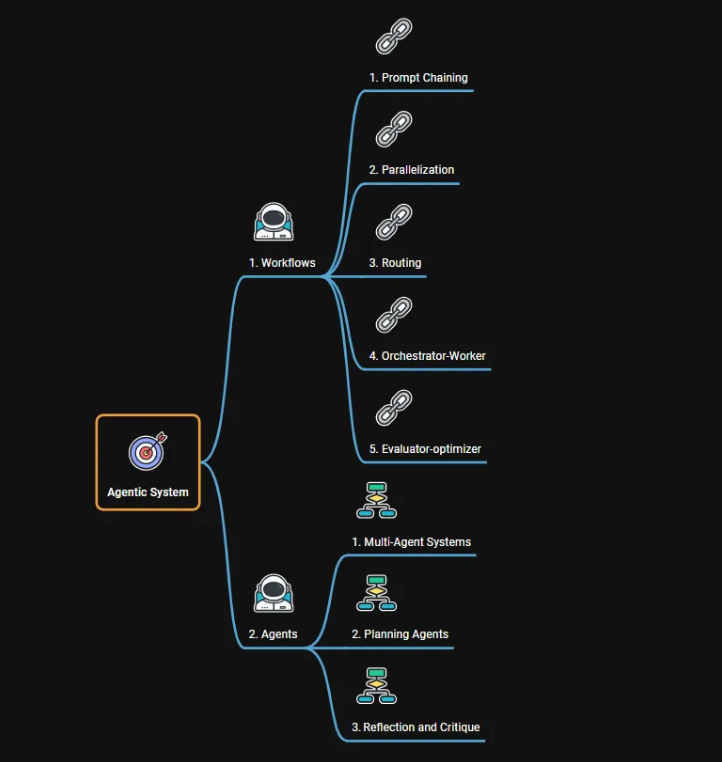

Detailed Blog : https://aiproductplaybook.substack.com/p/101-what-the-heck-are-agentic-system

# 3. Agents - Multiagent System (Network )

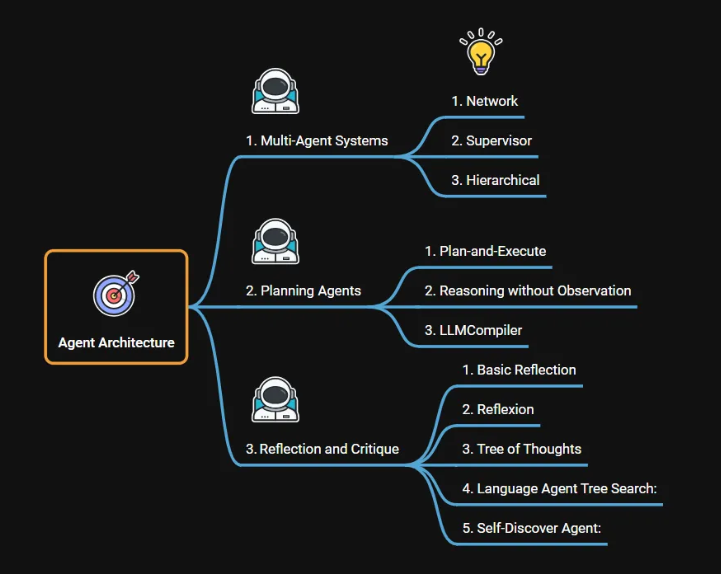

Detailed Blog : https://aiproductplaybook.substack.com/p/107-what-the-heck-are-multi-agent

### a. Define the tools

1. Import necessary dependencies

2. Creating a Tavily Search Tool

a. create an instance of the TavilySearchResults class, which is likely used to interact with the Tavily search engine.

b. max_results=5 specifies that the tool should retrieve a maximum of 5 search results when queried.

3. Creating a Python REPL Tool

a. This code defines a function python_repl_tool that is decorated with the @tool decorator. This indicates that this function can be used as a tool by a language model.

b. The function takes one argument: code, which represents the Python code to be executed.

c. The Annotated class is used to provide a type hint for code and a helpful description.

d. The function attempts to execute the provided Python code using the repl.run() method.

e. If the execution is successful, it returns a formatted string that includes the successfully executed code and the output of the execution.

f. If an error occurs during execution, it returns an error message.

g. The function also includes a reminder to respond with "FINAL ANSWER" if all tasks are completed.


In [109]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

tavily_tool = TavilySearchResults(max_results=5)

# Warning: This executes code locally, which can be unsafe when not sandboxed

repl = PythonREPL()


@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

### b. Create a helper function to generate system prompt

This code block defines a function that generates a system prompt for an AI assistant. The prompt is designed to encourage collaboration and progress towards a shared goal, while also providing a mechanism for indicating when the final answer has been reached. The use of suffix allows for customization of the prompt based on the specific task or context.



In [110]:
def make_system_prompt(suffix: str) -> str:
    return (
        "You are a helpful AI assistant, collaborating with other assistants."
        " Use the provided tools to progress towards answering the question."
        " If you are unable to fully answer, that's OK, another assistant with different tools "
        " will help where you left off. Execute what you can to make progress."
        " If you or any of the other assistants have the final answer or deliverable,"
        " prefix your response with FINAL ANSWER so the team knows to stop."
        f"\n{suffix}"
    )

### c. Define Agent Node

1. Import necessary dependencies

2. Creating an OpenAI Chat Model

a. creates an instance of the ChatOpenAI class, which will be used to interact with the OpenAI API.

b. model="gpt-4o-mini" specifies the model to be used for generating text.

3. Defining get_next_node Function

a. This function determines the next node in the workflow based on the last message.

b. If the last message contains "FINAL ANSWER", it indicates that the task is complete, so the function returns END.

c. Otherwise, it returns the specified goto node (e.g., "chart_generator").

4. Creating the Research Agent

a. create_react_agent() is used to create a reactive agent for research.

b. llm: The OpenAI Chat model instance.

c. tools=[tavily_tool]: Specifies that the agent can use the tavily_tool (for searching information) to perform its tasks.

d. prompt: Provides a system prompt that guides the research agent, instructing it to focus on research and collaborate with a "chart generator" colleague.

5. Defining the research_node Function

a. This function defines the behavior of the "researcher" node.

b. It invokes the research_agent to perform research tasks.

c. It calls get_next_node to determine the next node in the workflow.

d. It wraps the last message in a HumanMessage for compatibility.

e. It creates and returns a Command object, which includes the updated state (message history) and the goto node.

6. Creating the Chart Generator Agent

a. This code creates a reactive agent for generating charts, similar to the research agent.

b. It provides the python_repl_tool as the available tool, enabling the agent to execute Python code.

c. The system prompt instructs the agent to focus on generating charts and collaborate with the "researcher" colleague.

7. Defining the chart_node Function

a. This function defines the behavior of the "chart_generator" node, similar to the research_node function.

b. It invokes the chart_agent to generate charts.

c. It determines the next node in the workflow using get_next_node.

d. It wraps the last message in a HumanMessage.

e. It creates and returns a Command object with the updated state and the goto node.

In [111]:
from typing import Literal

from langchain_core.messages import BaseMessage, HumanMessage
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent
from langgraph.graph import MessagesState, END
from langgraph.types import Command


llm = ChatOpenAI(model="gpt-4o-mini")


def get_next_node(last_message: BaseMessage, goto: str):
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return END
    return goto


# Research agent and node
research_agent = create_react_agent(
    llm,
    tools=[tavily_tool],
    prompt=make_system_prompt(
        "You can only do research. You are working with a chart generator colleague."
    ),
)


def research_node(
    state: MessagesState,
) -> Command[Literal["chart_generator", END]]:
    result = research_agent.invoke(state)
    goto = get_next_node(result["messages"][-1], "chart_generator")
    # wrap in a human message, as not all providers allow
    # AI message at the last position of the input messages list
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="researcher"
    )
    return Command(
        update={
            # share internal message history of research agent with other agents
            "messages": result["messages"],
        },
        goto=goto,
    )


# Chart generator agent and node
# NOTE: THIS PERFORMS ARBITRARY CODE EXECUTION, WHICH CAN BE UNSAFE WHEN NOT SANDBOXED
chart_agent = create_react_agent(
    llm,
    [python_repl_tool],
    prompt=make_system_prompt(
        "You can only generate charts. You are working with a researcher colleague."
    ),
)


def chart_node(state: MessagesState) -> Command[Literal["researcher", END]]:
    result = chart_agent.invoke(state)
    goto = get_next_node(result["messages"][-1], "researcher")
    # wrap in a human message, as not all providers allow
    # AI message at the last position of the input messages list
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="chart_generator"
    )
    return Command(
        update={
            # share internal message history of chart agent with other agents
            "messages": result["messages"],
        },
        goto=goto,
    )

### d. Define the Graph

This code block defines a basic workflow with two nodes: "researcher" and "chart_generator." The workflow starts with the "researcher" node and then proceeds based on the logic and decisions defined within the research_node and chart_node functions.

In [112]:
from langgraph.graph import StateGraph, START

workflow = StateGraph(MessagesState)
workflow.add_node("researcher", research_node)
workflow.add_node("chart_generator", chart_node)

workflow.add_edge(START, "researcher")
graph = workflow.compile()

### e. Visualize the Graph

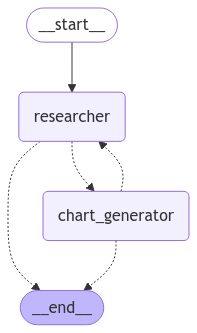

In [113]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

### f. Invoke the Agentic System

{'researcher': {'messages': [HumanMessage(content="First, get the India's GDP over the past 5 years, then make a line chart of it. Once you make the chart, finish.", additional_kwargs={}, response_metadata={}, id='66012fd3-fc70-4294-ace0-ba616ed21e6f'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_V97qKmKtddh1BLUwtg0nf2TB', 'function': {'arguments': '{"query":"India GDP past 5 years data"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 208, 'total_tokens': 233, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_13eed4fce1', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-32e0a4e6-367c-436f-a363-20b7948ec73f-0', tool_calls=[{'n

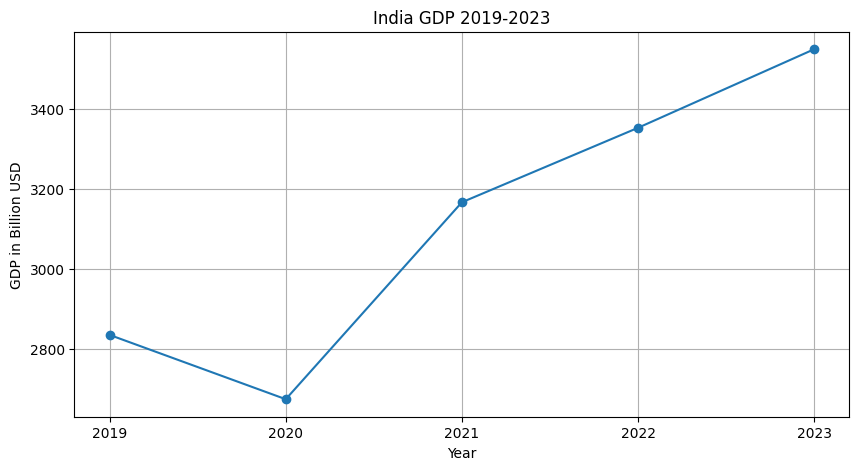

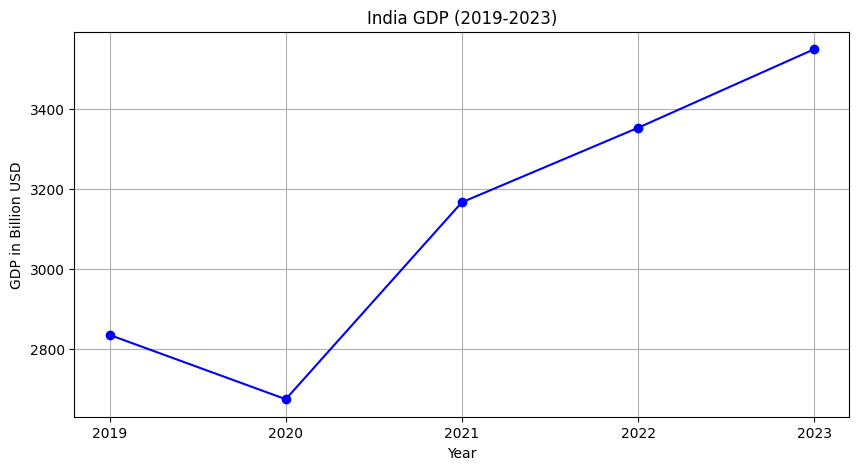

<Figure size 1000x500 with 0 Axes>

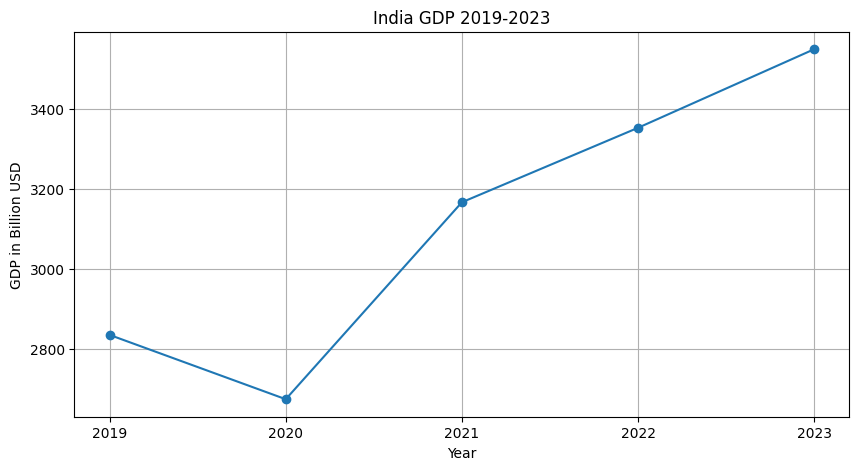

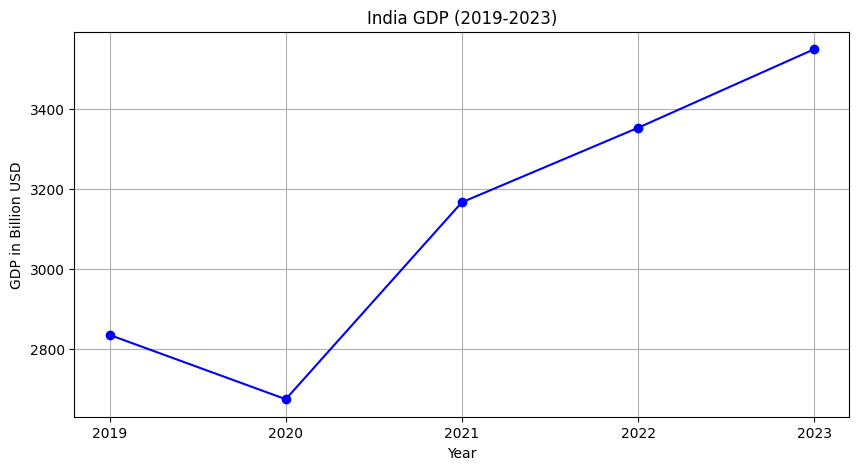

{'chart_generator': {'messages': [HumanMessage(content="First, get the India's GDP over the past 5 years, then make a line chart of it. Once you make the chart, finish.", additional_kwargs={}, response_metadata={}, id='66012fd3-fc70-4294-ace0-ba616ed21e6f'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_V97qKmKtddh1BLUwtg0nf2TB', 'function': {'arguments': '{"query":"India GDP past 5 years data"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 208, 'total_tokens': 233, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_13eed4fce1', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-32e0a4e6-367c-436f-a363-20b7948ec73f-0', tool_calls

In [117]:
events = graph.stream(
    {
        "messages": [
            (
                "user",
                "First, get the India's GDP over the past 5 years, then make a line chart of it. "
                "Once you make the chart, finish.",
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 150},
)
for s in events:
    print(s)
    print("----")

{'researcher': {'messages': [HumanMessage(content="First, get the Germany's GDP over the past 5 years, then make a line chart of it. Once you make the chart, finish.", additional_kwargs={}, response_metadata={}, id='da7b3fc3-213e-4e5f-ba1d-a40fe8d74e83'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_HDdaasjUxiKHvLLmKeyTX66x', 'function': {'arguments': '{"query":"Germany GDP data last 5 years"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 209, 'total_tokens': 234, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_13eed4fce1', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-e553e4ce-3c0b-4c4c-930b-2bebac9d0a2d-0', tool_calls=

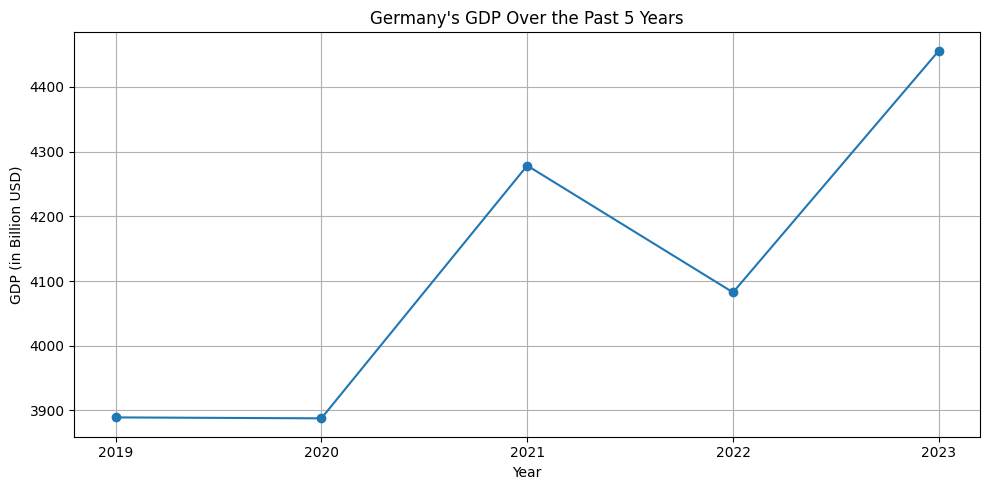

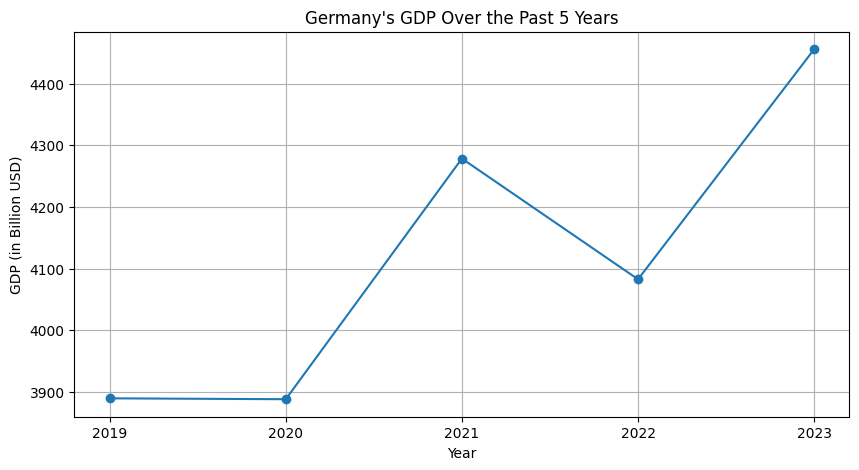

{'chart_generator': {'messages': [HumanMessage(content="First, get the Germany's GDP over the past 5 years, then make a line chart of it. Once you make the chart, finish.", additional_kwargs={}, response_metadata={}, id='da7b3fc3-213e-4e5f-ba1d-a40fe8d74e83'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_HDdaasjUxiKHvLLmKeyTX66x', 'function': {'arguments': '{"query":"Germany GDP data last 5 years"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 209, 'total_tokens': 234, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_13eed4fce1', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-e553e4ce-3c0b-4c4c-930b-2bebac9d0a2d-0', tool_c

In [118]:
events = graph.stream(
    {
        "messages": [
            (
                "user",
                "First, get the Germany's GDP over the past 5 years, then make a line chart of it. "
                "Once you make the chart, finish.",
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 150},
)
for s in events:
    print(s)
    print("----")